Using fastest pre-snap speed to determine which way a play is going.

In [2]:
import pandas as pd
import numpy as np

In [3]:
plays1 = pd.read_csv('../data/tracking_week_1.csv')
plays2 = pd.read_csv('../data/tracking_week_2.csv')
plays3 = pd.read_csv('../data/tracking_week_3.csv')
plays4 = pd.read_csv('../data/tracking_week_4.csv')

plays = pd.concat([plays1, plays2, plays3, plays4])

# Grab only items that are before and during the snap
plays = plays[plays['frameType'].isin(['BEFORE_SNAP', 'BALL_SNAP'])]

# drop rows that are about the football
plays = plays[plays['displayName'] != 'football']

In [4]:
# Find the player with the maximum 's' within each 'gameId' and 'playId'
max_s_players = plays.loc[plays.groupby(['gameId', 'playId'])['s'].idxmax()]
# Get the row before the maximum 's' within each 'gameId' and 'playId'
previous_rows = plays.loc[plays.index.isin(max_s_players.index - 1)]
# Combine the rows
max_s_players = pd.concat([previous_rows, max_s_players]).sort_index()

In [5]:
max_s_players['orientation_sin'] = np.sin(np.radians(max_s_players['o']))
max_s_players['orientation_cos'] = np.cos(np.radians(max_s_players['o']))

In [6]:
max_s_players['forward_velocity'] = max_s_players['s'] * max_s_players['orientation_cos']
max_s_players['sideways_velocity'] = max_s_players['s'] * max_s_players['orientation_sin']

In [7]:
def determine_player_direction(df):
    # Ensure the dataframe is sorted by gameId, playId, and frameId
    df = df.sort_values(by=['gameId', 'playId', 'frameId'])
    
    # Calculate the difference in y values between consecutive frames
    df['y_diff'] = df.groupby(['gameId', 'playId'])['y'].diff()
    
    # Define the conditions for the new column
    conditions = [
        (df['o'] > 180) & (df['y_diff'] > 0),
        (df['o'] > 180) & (df['y_diff'] < 0),
        (df['o'] < 180) & (df['y_diff'] > 0),
        (df['o'] < 180) & (df['y_diff'] < 0)
    ]
    
    # Define the corresponding values for the new column
    choices = ['right', 'left', 'left', 'right']
    
    # Create the new column based on the conditions
    df['player_direction'] = np.select(conditions, choices, default=np.nan)
    
    return df

# Apply the function to the max_s_players dataframe
max_s_players = determine_player_direction(max_s_players)

In [8]:
max_s_players = max_s_players.dropna(subset=['y_diff'])

In [9]:
max_s_players['player_going_right'] = pd.get_dummies(max_s_players['player_direction'])['right']
max_s_players.drop(columns=['player_direction'], inplace=True)

In [10]:
df = max_s_players[['playId', 'gameId', 'frameId', 'x', 'y', 's', 'a', 'dis', 'o', 'dir', 'orientation_sin', 'orientation_cos', 'forward_velocity', 'sideways_velocity', 'y_diff', 'player_going_right']]

In [11]:
df_join = pd.read_csv('../data/play_direction.csv')

In [12]:
# Merge df and df_join on gameId and playId
merged_df = pd.merge(df, df_join, how='inner', left_on=['gameId', 'playId'], right_on=['gameId', 'playId'])

In [13]:
# Define the conditions for the new column
conditions = [
    (merged_df['y_difference'] < 0) & (merged_df['playDirection'] == 'right'),
    (merged_df['y_difference'] > 0) & (merged_df['playDirection'] == 'right'),
    (merged_df['y_difference'] < 0) & (merged_df['playDirection'] == 'left'),
    (merged_df['y_difference'] > 0) & (merged_df['playDirection'] == 'left')
]

# Define the corresponding values for the new column
choices = [1, 0, 0, 1]

# Create the new column based on the conditions
merged_df['target_right'] = np.select(conditions, choices, default=np.nan)

In [14]:
merged_df.drop(columns=['playId', 'gameId', 'playDirection', 'y_difference'], inplace=True)

In [15]:
merged_df = merged_df.dropna()

In [16]:
merged_df.columns

Index(['frameId', 'x', 'y', 's', 'a', 'dis', 'o', 'dir', 'orientation_sin',
       'orientation_cos', 'forward_velocity', 'sideways_velocity', 'y_diff',
       'player_going_right', 'target_right'],
      dtype='object')

In [17]:
from sklearn.model_selection import train_test_split

# Define the features and target variable
X = merged_df.drop(columns=['target_right'])
y = merged_df['target_right']

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (6989, 14)
X_test shape: (1748, 14)
y_train shape: (6989,)
y_test shape: (1748,)


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7448512585812357
Classification Report:
               precision    recall  f1-score   support

         0.0       0.77      0.72      0.74       891
         1.0       0.72      0.77      0.75       857

    accuracy                           0.74      1748
   macro avg       0.75      0.75      0.74      1748
weighted avg       0.75      0.74      0.74      1748



In [19]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# Convert target variables to categorical format
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

# Convert input data to float
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# Define the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_categorical, epochs=50, batch_size=10, verbose=1)

# Make predictions on the test set
y_pred_categorical = model.predict(X_test)
y_pred = y_pred_categorical.argmax(axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Epoch 1/50
699/699 [==============================] - 1s 838us/step - loss: 1.3448 - accuracy: 0.4901
Epoch 2/50
699/699 [==============================] - 1s 818us/step - loss: 0.8881 - accuracy: 0.5127
Epoch 3/50
699/699 [==============================] - 1s 811us/step - loss: 0.8615 - accuracy: 0.5098
Epoch 4/50
699/699 [==============================] - 1s 820us/step - loss: 0.8055 - accuracy: 0.5048
Epoch 5/50
699/699 [==============================] - 1s 905us/step - loss: 0.7972 - accuracy: 0.5174
Epoch 6/50
699/699 [==============================] - 1s 909us/step - loss: 0.7799 - accuracy: 0.5220
Epoch 7/50
699/699 [==============================] - 1s 819us/step - loss: 0.7686 - accuracy: 0.5200
Epoch 8/50
699/699 [==============================] - 1s 811us/step - loss: 0.7355 - accuracy: 0.5245
Epoch 9/50
699/699 [==============================] - 1s 805us/step - loss: 0.7470 - accuracy: 0.5171
Epoch 10/50
699/699 [==============================] - 1s 802us/step - loss: 0.729

In [20]:
import joblib

# Export the trained model to the specified directory
joblib.dump(rf_classifier, '../models/rf_classifier.pkl')

['../models/rf_classifier.pkl']

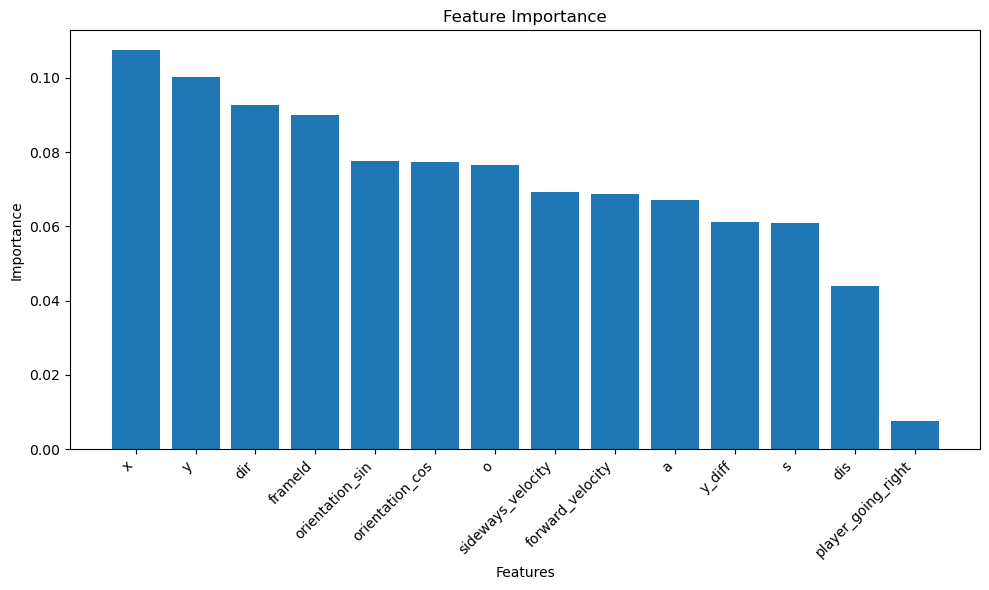

In [22]:
import matplotlib.pyplot as plt
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()